# Avaliação - semana 15
## FSC5705 - Física Computacional
## 13/11/2023

### Atenção
- **Não esqueça de reiniciar o kernel e rodar todas as células para testar o notebook antes de enviar.**

## Gás ideal quântico

Vamos utilizar o método de Monte Carlo com Cadeias de Markov (MCMC) para simular um gás composto de partículas quânticas dentro de uma caixa.

### Partícula dentro de uma caixa

Uma partícula ou um átomo de um gás dentro de uma caixa pode ser descrita quanticamente como uma onda estacionária. Assim como ondas numa corda de violão, existem várias harmônicas possíveis, com frequências múltiplas inteiras da frequência fundamental.  

![Potencial de caixa mostrando ondas senoidais com n=1,2,3 e 4.](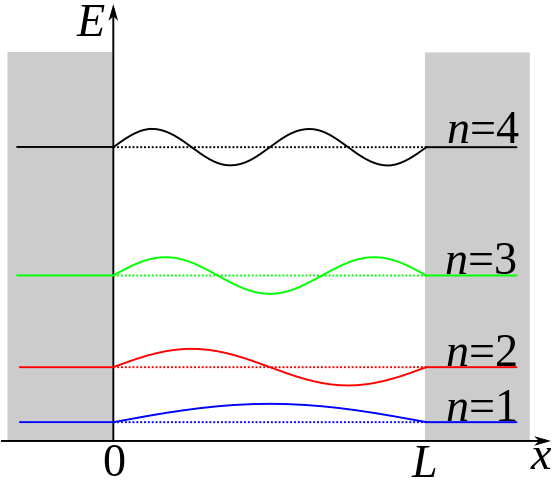
)

CC BY-SA 3.0 [Papa November](https://pt.wikipedia.org/wiki/Part%C3%ADcula_em_uma_caixa#/media/Ficheiro:Particle_in_a_box_wavefunctions.svg)

O estado da partícula pode ser descrito port três números quânticos, que ditam a harmônica da oscilação em cada dimensão da caixa, que são $n_x, n_y, n_z = 1, 2, 3, \ldots, \infty$. Se temos uma caixa cúbica de lado $L$, resolvendo a equação de Schrödinger, pode-se mostrar que a energia de uma partícula de massa $m$ é

\begin{align}
E(n_x, n_y, n_z) = \frac{\pi^2\hbar^2}{2 m L^2} (n_x^2 + n_y^2 + n_z^2).
\end{align}

### Muitas partículas não-interagentes

Um gás ideal contém $N$ partículas destas, que não interagem entre si, de tal forma que a energia total do gás é simplesmente

\begin{align}
E = \sum_{i=1}^N E(n_{x,i}, n_{y,i}, n_{z,i}),
\end{align}

onde $n_{x,i}, n_{y,i}$ e  $n_{z,i}$ são os números quânticos da partícula $i$. Cada combinação possível de números quânticos de todas as $N$ partículas é um estado $\Theta_j$ do sistema. Da mecânica estatística, sabemos que a probabilidade do sistema, a uma temperatura $T$, estar no estado $\Theta_j$ com energia $E_j$ é dada pela fórmula de Boltzmann

\begin{align}
P(E_j) &= \frac{\mathrm{e}^{-\beta E_j}}{Z} \\
Z &= \sum_j \mathrm{e}^{-\beta E_j},
\end{align}

onde $\beta = \frac{1}{k_\mathrm{B} T}$ e $k_\mathrm{B}$ é a constante de Boltzmann, e o somatório de $Z$ é sobre todos os infinitos estados possíveis. Note que, diferente da formulação integral que vimos anteriormente, aqui os estados possíveis do sistema são discretos, por isso o somatório.

### Simulação com MCMC
Se temos interesse em conhecer, por exemplo, o valor esperado da energia, precisamos calcular

\begin{align}
\langle E \rangle = \sum_j E_j\,P(E_j).
\end{align}


Esse somatório é intratável, temos infinitos termos. Porém, uma pequeníssima fração dos estados possíveis contribui com a maioria do valor do somatório. O procedimento que precisamos adotar é o mesmo do problema visto na semana passada: trocar um somatório intratável por uma "amostragem por importância", quer dizer, aplicar o método *importance sampling*.

Compare a probabilidade acima com a que estudamos no ajuste de modelo. Temos uma forma equivalente, mas aqui $\beta E_j$ faz o papel de $\frac 1 2 \chi^2_j$. Todo o desenvolvimento que fizemos então pode ser usado neste probema, fazendo apenas esta substituição.

#### Algoritmo Metropolis–Hastings

Seguindo o algoritmo de Metropolis–Hastings, com uma função proposta adequada, podemos conseguir uma matriz $T_{jk}$ que nos dá a probabilidade de transição do estado $j$, de energia $E_j$, até o estado $k$, de energia $E_k$, obedecendo o balanço detalhado. Sorteamos um salto segundo a função proposta, que é aceito segundo a probabilidade de aceitação

\begin{align}
P_a &= \frac{q(\Theta_j, \Theta_k)}{q(\Theta_k, \Theta_j)}\ \frac{P(\Theta_k)}{P(\Theta_j)} \exp \left[-\beta (E_k - E_j)\right].
\end{align}

Repare que números quânticos menores que 1 são impossíveis, se um salto desses for proposto, $P(\Theta_k) = 0 \implies P_a = 0$. Admitimos que os estados $\Theta_j$ permitidos são todos igualmente prováveis, logo

$$
\frac{P(\Theta_k)}{P(\Theta_j)} = 1.
$$

#### Função proposta

Queremos fazer uma simulação de Monte Carlo para calcular o valor esperado da energia interna do gás. Primeiro, precisamos definir a nossa função proposta, que nos dá, a partir de um estado $j$, um estado candidato $k$ para tentarmos fazer a transição. Neste caso, vamos admitir que os saltos possíveis são tais que uma única partícula muda para um estado vizinho no qual somente um dos números quânticos $n_x$, $n_y$ ou $n_z$ difere por $+1$ ou $-1$. Em outras palavras escolhemos uma partícula aleatória, desta escolhemos aleatoriamente um dos três números quânticos, e por fim uma mudança aleatória do tipo "lançamento de moeda" de $+1$ ou $-1$.

É fácil se convencer de que a função proposta é simétrica, quer dizer, $q(\Theta_j, \Theta_k) = q(\Theta_k, \Theta_j)$. Neste caso, a probabilidade de aceitação é

\begin{align}
P_a &= \exp \left[-\beta (E_k - E_j)\right].
\end{align}

Ou seja, transições para estados de energia menor são sempre aceitos, enquanto transições para estados de energia maior são aceitos com probabilidade $\exp\left[-\beta (E_k - E_j)\right]$. Vamos explorar o fato de que a nossa função proposta muda muito pouco o estado do sistema. Como a probabilidade de aceitação está definida em termos da diferença da energia, é mais interessante trabalhar com $\Delta E_{jk} = E_k - E_j$. Desse modo, também evitamos ter que calcular a soma das energias de todas as partículas a cada passo.

Como num salto todas as partículas ficam com a mesma energia, exceto a que escolhemos para o salto, todos os termos se cancelam, exceto o referente à particula que escolhemos. Assim, para um salto que modifica $n_x$ por $\delta n = \pm 1$,

\begin{align}
\Delta E_{jk} &= \frac{\pi^2\hbar^2}{2 m L^2} \left[(n_x + \delta n)^2 + n_y^2 + n_z^2 \right]
- \frac{\pi^2\hbar^2}{2 m L^2} (n_x^2 + n_y^2 + n_z^2) \\
&= \frac{\pi^2\hbar^2}{2 m L^2}\left[(n_x + \delta n)^2 - n_x^2\right] \\
&= \frac{\pi^2\hbar^2}{2 m L^2}\left(n_x^2 + 2 \delta n\,n_x + (\delta n)^2 - n_x^2\right) \\
&= \frac{\pi^2\hbar^2}{2 m L^2}\left(2\delta n\,n_x + 1\right).
\end{align}

Por simetria, o mesmo acontece para um salto em $n_y$ ou em $n_z$. A probabilidade de aceitação fica

\begin{align}
P_a = \left\{ \
\begin{array}{ll}
\mathrm{e}^{-\beta \Delta E_{jk}},\qquad &\mathrm{se}\ \Delta E_{jk} > 0 \\
1, &\mathrm{se}\ \Delta E_{jk} \leq 0.
\end{array}
\right.
\end{align}

Se o salto é aceito, atualizamos a energia atual tal que $E_k = E_j + \Delta E_{jk}$. Por outro lado, se o passo não é aceito, o sistema segue no mesmo estado, e $E_k = E_j$. É interessante notar que se $\delta n < 0$, a energia diminiu, e o salto é imediatamente aceito. Podemos usar isto para simplificar os testes de aceitação do salto, como fizemos no problema anterior.

### Programando a simulação

Nós precisamos conhecer o estado de cada partícula para poder calcular a diferença de energia. Diferente do que fizemos no ajuste linear, não vamos guardar o estado de todas as partículas a cada passo de tempo. Isso não seria prático pois restringiria o número de partículas que podemos simular dadas as limitações de memória dos computadores. Assim, precisamos calcular as quantidades de interesse a cada passo. Neste exemplo, queremos apenas a energia total do sistema, mas poderíamos calcular qualquer função dos números quânticos das partículas, como capacidade térmica, entropia, pressão, etc.

Vamos então definir alguns valores. Por simplicidade, considere que $k_\mathrm{B}T = 10$, $m = 1$, $\hbar = 1$, e $L=1$. Vamos simular $N=1000$ partículas, e vamos admitir que no estado inicial do sistema todas as partículas estão no estado fundamental, $n_x=n_y=n_z=1$.

Os números quânticos de todas partícula serão representados por uma matriz, onde cada linha representa uma partícula, com 3 colunas para $n_x$, $n_y$ e $n_z$. Assim, armazenaremos o estado do sistema em um array bidimensional de $N \times 3$. Os números $n_x$, $n_y$ e $n_z$ da partícula $i$ devem ser acessados como `n[i, 0]`, `n[i, 1]` e `n[i, 2]` respectivamente.

In [103]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'stix'

In [104]:
import numpy as np

kBT = 10.0
beta = 1.0 / kBT
m = 1.0
hbar = 1.0
L = 1.0
N = 1000
# Todas as partículas iniciam com nx = ny = nz = 1
n = np.ones((N, 3), dtype='int32')

Vamos simular o sistema por 250 mil passos, e guardar todos os valores de $E_j$.

In [105]:
M = 500_000
E = np.zeros(M)

#### Item 1
Calcule a energia inicial do sistema, e guarde na primeira posição do array de energias.

In [106]:
def E0(N):
    return 3*N*((np.pi**2 * hbar**2) / (2 * m * L**2))

print(f'E0 = {E0(N)}')

E0 = 14804.406601634037


#### Item 2

Faça a simulação, que consiste nos seguintes passos a cada iteração:

- Realize a função proposta:
    - Escolha uma partícula aleatória.
    - Escolha um número quântico aleatório.
    - Escolha uma direção aleatória de salto.
- Calcule a variação de energia total.
- Decida se o salto é aceito através da matriz de transição.
- Guarde o valor da energia total atual no array.

**É importante notar que os números quânticos devem ser maiores do que zero, logo devemos rejeitar o salto se isto for acontecer.**

In [107]:
def f_proposta(n):
    
    particula = np.random.randint(N)   
    num_quantico = np.random.randint(3)   
    delta = 0

    r = np.random.rand()  

    if r > 0.5:
        delta = 1

    else:
        delta = -1
        
    return particula, num_quantico, delta

In [108]:
def calc_variaçãoEnergia(n):
    
    particula_aleatória = f_proposta(n)[0]   
    numero_quantico = f_proposta(n)[1]   
    delta = f_proposta(n)[2]   
    nn = n[particula_aleatória,numero_quantico]

    deltaE = ((np.pi**2 * hbar**2) / (2 * m * L**2)) * ((2 * delta * nn) + 1)

    return deltaE, particula_aleatória, numero_quantico, nn, delta

In [109]:
E[0] = E0(N)
 
for j in range(1,M):

    CONJUNTO = list(calc_variaçãoEnergia(n))
    deltaE = CONJUNTO[0]
    particula_aleatoria =CONJUNTO[1]
    numero_quantico = CONJUNTO[2]
    n_atual = CONJUNTO[3]
    delta1 = CONJUNTO[4]
    
    if deltaE < 0:
    
        if n_atual > 1:    
            E[j] = E[j-1] + deltaE 
            n[particula_aleatoria,numero_quantico] += delta1
            
        else:
            E[j] = E[j-1] 
            n[particula_aleatoria,numero_quantico] = n[particula_aleatoria,numero_quantico]
    
    else:
        
        if n_atual > 0 :
            
            Pa = np.exp(-beta * deltaE)
            r = np.random.rand()
            
            if r < Pa:
        
                E[j] = E[j-1] + deltaE 
                n[particula_aleatoria,numero_quantico] += delta1
                    
            else:
                E[j] = E[j-1] 
                n[particula_aleatoria,numero_quantico] = n[particula_aleatoria,numero_quantico]
                
        else:
            E[j] = E[j-1] 
            n[particula_aleatoria,numero_quantico] = n[particula_aleatoria,numero_quantico]

#### Item 3

Calcule o valor esperado da energia do sistema.

In [110]:
comp = len(E)
E_esp = np.sum(E)/comp
print(f"O valor da energia esperada é: {E_esp:.3f}")

O valor da energia esperada é: 24691.874


#### Item 4

Vamos agora analisar melhor os resultados. Primeiro, vamos ver como a cadeia evolui. Faça o gráfico da energia total a cada passo. Desenhe também uma linha tracejada onde fica o valor esperado da energia.

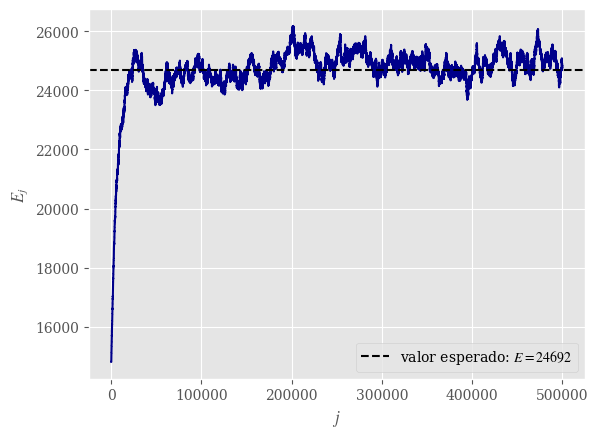

In [111]:
passos = np.arange(1,500_001,1)

fig, ax = plt.subplots(1,1)

ax.plot(passos,E, color = "darkblue")
ax.set_xlabel(r"$j$")
ax.set_ylabel(r"$E_{j}$")
ax.axhline(E_esp,0, ls = "--", color = "black", label = f"valor esperado: $E = {E_esp:.0f}$")
ax.legend()

Veja que a energia do estado inicial é muito diferente do valor esperado, ao redor do qual a cadeia "termaliza" após um certo número de passos, isto é, fica passeando de forma estacionária conforme a PDF do sistema. Este transiente entre o estado inicial e o regime estacionário é o chamado *burn-in*. Isto é debatível, até mesmo questão de opinião, mas é costume descartar esta primeira etapa da simulação. Neste caso, o burn-in levou aproximadamente 50 mil passos. Você pode descartar o burn-in fazendo, por exemplo, um slice do tipo `E[50000:]`.

#### Item 5

Faça o histograma da energia do sistema (array `E`), que é uma aproximação da PDF $P(E)$.

Text(0.5, 0, '$E_{j}$')

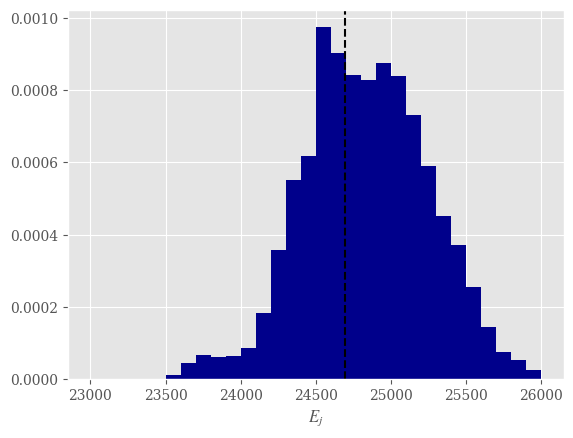

In [112]:
fig, ax = plt.subplots(1,1)

ax.hist(E[50000:],bins = 30, range=[23000,26000], color = "darkblue", density= True)
ax.axvline(E_esp,0,ls = "--", color = "black")
ax.set_xlabel(r"$E_{j}$")

Se você manteve a configuração original do notebook, e dependendo do gerador de números aleatórios do seu computador, a distribuição deve parecer assimétrica, e com múltiplos picos. Mude a semente da simulação, e veja que esta distribuição muda bastante. Provavelmente rodamos a simulação por poucos passos. Experimente dobrar o número de passos e refazer a simulação. Fazendo isso, certamente a distribuição passa a ser mais bem comportada. O esperado é que com um $N$ suficientemente grande nos aproximemos da PDF real do sistema.

#### Item 6

Embora tenhamos descartado o histórico de estados do sistema, podemos ainda analisar o estado que o sistema ficou no último passo da simulação. Calcule qual a fração dos números quânticos ficaram em $n=1$, quantos em $n=2$, e assim por diante.

**Dica**: talvez seja conveniente desenhar um histograma.

In [113]:
quant_n1 = 0
quant_n2 = 0
quant_n3 = 0

for i in range(N):

    for j in range(3):
        
        if n[i,j] == 1:
            quant_n1 += 1
        
        if n[i,j] == 2:
            quant_n2 += 1

        if n[i,j] == 3:
            quant_n3 += 1

quant_n1 = 100*(quant_n1/(3*N))
quant_n2 = 100*(quant_n2/(3*N))
quant_n3 = 100*(quant_n3/(3*N))

print(f"n1 = {quant_n1:.2f}% | n2 = {quant_n2:.2f}$ | n3 = {quant_n3:.2f}%")

n1 = 80.23% | n2 = 18.27$ | n3 = 1.43%


Nas configurações originais, aproximadamente 80% dos números quânticos são $n=1$, 20% são $n=2$, e uma ninharia é maior que isso. Experimente mudar a temperatura do sistema, por exemplo, $k_\mathrm{B}T = 20$. O que acontece com a energia e a distribuição de números quânticos? Dependendo da temperatura, pode ser necessário aumentar o número de passos, pois o estágio de burn-in pode demorar muito e atrapalhar a distribuição.

Para finalizar, descubra o que acontece quando se aumenta o número de partículas para $N=2000$. Experimente com a temperatura e com o número de passos de simulação. A ideia é ter um entendimento intuitivo desta simulação de Monte Carlo.